In [1]:
%config InlineBackend.figure_formats = ['svg']

In [2]:
from time import time

import numpy as np
import rustworkx as rx

import matplotlib.pyplot as plt

from qiskit import transpile
from qiskit.circuit import Parameter
from qiskit.opflow import VectorStateFn

from qiskit.circuit.library import EfficientSU2
from qiskit.primitives import Estimator
from qiskit.algorithms import NumPyEigensolver as ClassicalEigensolver, MinimumEigensolver, VQEResult
from qiskit.algorithms.optimizers import SLSQP, COBYLA, L_BFGS_B, ADAM, GradientDescent, NFT

from qiskit_nature.problems.second_quantization.lattice import Lattice
from qiskit_nature.mappers.second_quantization import LogarithmicMapper

from heisenberg_model import HeisenbergModel

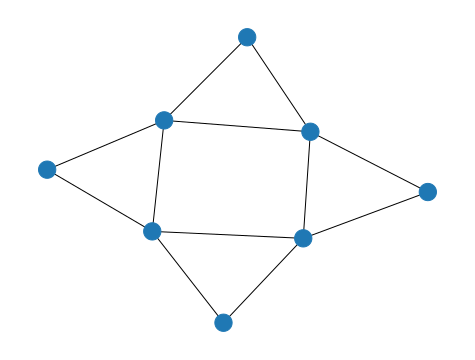

In [5]:
num_sites = 8
t = 1.0

graph = rx.PyGraph(multigraph=False)
graph.add_nodes_from(range(num_sites))
edge_list = [
    (0, 1, t),
    (1, 2, t),
    (2, 3, t),
    (3, 0, t),
    (0, 4, t),
    (4, 1, t),
    (1, 5, t),
    (5, 2, t),
    (2, 6, t),
    (6, 3, t),
    (3, 7, t),
    (7, 0, t)
]

graph.add_edges_from(edge_list)
line_unit_cell = Lattice(graph)

line_unit_cell.draw()
plt.show()

In [6]:
heisenberg_model = HeisenbergModel.uniform_parameters(
    lattice=line_unit_cell,
    uniform_interaction=1.0,
    uniform_onsite_potential=0.0,
)

logarithmic_mapper = LogarithmicMapper()
hamiltonian = 4 * logarithmic_mapper.map(heisenberg_model.second_q_ops().simplify())
hamiltonian

PauliSumOp(SparsePauliOp(['ZIIIZIII', 'IZIIZIII', 'IZIIIZII', 'IIZIIZII', 'IIIIZZII', 'IIZIIIZI', 'IIIZIIZI', 'IIIIIZZI', 'ZIIIIIIZ', 'IIIZIIIZ', 'IIIIZIIZ', 'IIIIIIZZ', 'YIIIYIII', 'IYIIYIII', 'IYIIIYII', 'IIYIIYII', 'IIIIYYII', 'IIYIIIYI', 'IIIYIIYI', 'IIIIIYYI', 'YIIIIIIY', 'IIIYIIIY', 'IIIIYIIY', 'IIIIIIYY', 'XIIIXIII', 'IXIIXIII', 'IXIIIXII', 'IIXIIXII', 'IIIIXXII', 'IIXIIIXI', 'IIIXIIXI', 'IIIIIXXI', 'XIIIIIIX', 'IIIXIIIX', 'IIIIXIIX', 'IIIIIIXX'],
              coeffs=[1.+0.j, 1.+0.j, 1.+0.j, 1.+0.j, 1.+0.j, 1.+0.j, 1.+0.j, 1.+0.j, 1.+0.j,
 1.+0.j, 1.+0.j, 1.+0.j, 1.+0.j, 1.+0.j, 1.+0.j, 1.+0.j, 1.+0.j, 1.+0.j,
 1.+0.j, 1.+0.j, 1.+0.j, 1.+0.j, 1.+0.j, 1.+0.j, 1.+0.j, 1.+0.j, 1.+0.j,
 1.+0.j, 1.+0.j, 1.+0.j, 1.+0.j, 1.+0.j, 1.+0.j, 1.+0.j, 1.+0.j, 1.+0.j]), coeff=1)

In [13]:
exact_solver = ClassicalEigensolver(k=2)
exact_result = exact_solver.compute_eigenvalues(hamiltonian)
print(exact_result.eigenvalues)

gs_energy = exact_result.eigenvalues[0]

[-12. -12.]


In [33]:
for index, amplitude in enumerate(exact_result.eigenstates[0].primitive.data):
    if not np.isclose(np.abs(amplitude), 0):
        print(f"{index:0{num_sites}b}: {np.abs(amplitude)}, {np.angle(amplitude):.2f}")

00001111: 0.31192607770047404, -2.37
00011101: 0.09006071146434032, 0.69
00011110: 0.2223014683468491, 0.80
00101011: 0.09006071146434025, 0.69
00101101: 0.22230146834684933, 0.80
00111001: 0.09006071146434028, -2.45
00111100: 0.222301468346849, -2.34
01000111: 0.09006071146433983, 0.69
01001011: 0.22230146834684972, 0.80
01010101: 0.09006071146434019, -2.45
01011010: 0.22230146834684936, -2.34
01100011: 0.09006071146434012, -2.45
01101001: 0.2223014683468498, -2.34
01110001: 0.09006071146434022, 0.69
01111000: 0.22230146834684952, 0.80
10000111: 0.2223014683468491, 0.80
10001110: 0.0900607114643402, 0.69
10010110: 0.222301468346849, -2.34
10011100: 0.09006071146434047, -2.45
10100101: 0.2223014683468492, -2.34
10101010: 0.0900607114643402, -2.45
10110100: 0.22230146834684889, 0.80
10111000: 0.0900607114643407, 0.69
11000011: 0.22230146834684927, -2.34
11000110: 0.09006071146433978, -2.45
11010010: 0.22230146834684925, 0.80
11010100: 0.09006071146434037, 0.69
11100001: 0.22230146834684

In [24]:
for index, statevector in enumerate(exact_result.eigenstates):
    print(f"Ground State #{index}")

    states = [f"{state:0{num_sites}b}" for state in range(2**num_sites)]
    probabilities = [ np.abs(statevector.primitive.data[state]) ** 2 for state in range(2**num_sites) ]

    # plt.figure(figsize=(350, 260))
    # plt.bar([f"$|{state}\\rangle$" for state in states], probabilities)
    # plt.xlabel("State")
    # plt.ylabel("Probability")
    # plt.title(f"Ground State #{index} Probability Distribution")
    # plt.show()

    print("Probabilities")
    for state, probability in zip(states, probabilities):
        print(f"\t|{state}> ==> {probability:.3f}")

    print()

Ground State #0
Probabilities
	|00000000> ==> 0.000
	|00000001> ==> 0.000
	|00000010> ==> 0.000
	|00000011> ==> 0.000
	|00000100> ==> 0.000
	|00000101> ==> 0.000
	|00000110> ==> 0.000
	|00000111> ==> 0.000
	|00001000> ==> 0.000
	|00001001> ==> 0.000
	|00001010> ==> 0.000
	|00001011> ==> 0.000
	|00001100> ==> 0.000
	|00001101> ==> 0.000
	|00001110> ==> 0.000
	|00001111> ==> 0.097
	|00010000> ==> 0.000
	|00010001> ==> 0.000
	|00010010> ==> 0.000
	|00010011> ==> 0.000
	|00010100> ==> 0.000
	|00010101> ==> 0.000
	|00010110> ==> 0.000
	|00010111> ==> 0.000
	|00011000> ==> 0.000
	|00011001> ==> 0.000
	|00011010> ==> 0.000
	|00011011> ==> 0.000
	|00011100> ==> 0.000
	|00011101> ==> 0.008
	|00011110> ==> 0.049
	|00011111> ==> 0.000
	|00100000> ==> 0.000
	|00100001> ==> 0.000
	|00100010> ==> 0.000
	|00100011> ==> 0.000
	|00100100> ==> 0.000
	|00100101> ==> 0.000
	|00100110> ==> 0.000
	|00100111> ==> 0.000
	|00101000> ==> 0.000
	|00101001> ==> 0.000
	|00101010> ==> 0.000
	|00101011> ==> 0.008
	|